In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('/content/drive/MyDrive/machine learning/merged dataset_FE_LM_GC_DC_class balancer.csv',
                    sep=',', encoding='iso-8859-1')

In [4]:
import warnings
warnings.filterwarnings("ignore")

## **PREDICTOR AND TARGET ATTRIBUTES**

In [5]:
predictors_chi_norm25 = df.iloc[:, [10,14,15,19,25,27,30,31,33,36,37,38,40,41,45,46,53,56,62,63,64]].values

binary_target = df.iloc[:, 5].values
multiclass_target = df.iloc[:, 7].values

# **Binary Code Smell Detection**

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96       134
         1.0       0.93      0.97      0.95       114

    accuracy                           0.96       248
   macro avg       0.95      0.96      0.96       248
weighted avg       0.96      0.96      0.96       248



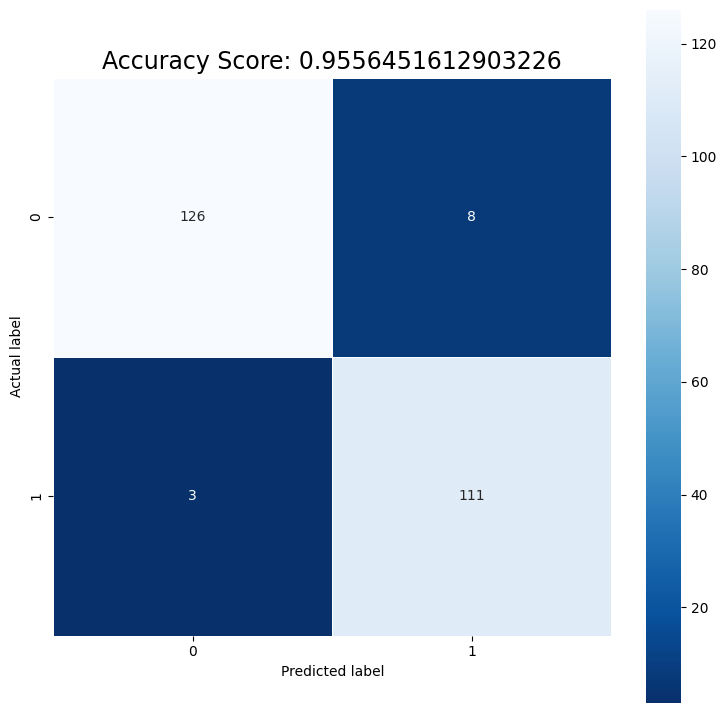

In [6]:
predictors_array = predictors_chi_norm25
r = 42
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

x_train_binary, x_test_binary, y_train_binary, y_test_binary = train_test_split(predictors_array, binary_target, test_size = 0.3, random_state = r)

x_train_multiclass, x_test_multiclass, y_train_multiclass, y_test_multiclass = train_test_split(predictors_array, multiclass_target, test_size = 0.3, random_state = r)


# Define the detector model
detector = XGBClassifier(random_state=r, verbosity=0, tree_method='approx', n_estimators=58, max_depth=5,
                         learning_rate=0.24655172413793103, grow_policy='depthwise', booster='gbtree')

detector.fit(x_train_binary, y_train_binary)
predictions_detector = detector.predict(x_test_binary)


cm = confusion_matrix(y_test_binary, predictions_detector)

print(classification_report(y_test_binary, predictions_detector))

score = detector.score(x_test_binary, y_test_binary)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

#**BINARY XGBOOST WITH CUDA**

{'tree_method': 'approx', 'n_estimators': 118, 'max_depth': 3, 'learning_rate': 0.11137931034482758, 'grow_policy': 'depthwise', 'booster': 'gbtree'};98.79;93.15
              precision    recall  f1-score   support

         0.0       0.97      0.90      0.93       134
         1.0       0.89      0.96      0.93       114

    accuracy                           0.93       248
   macro avg       0.93      0.93      0.93       248
weighted avg       0.93      0.93      0.93       248



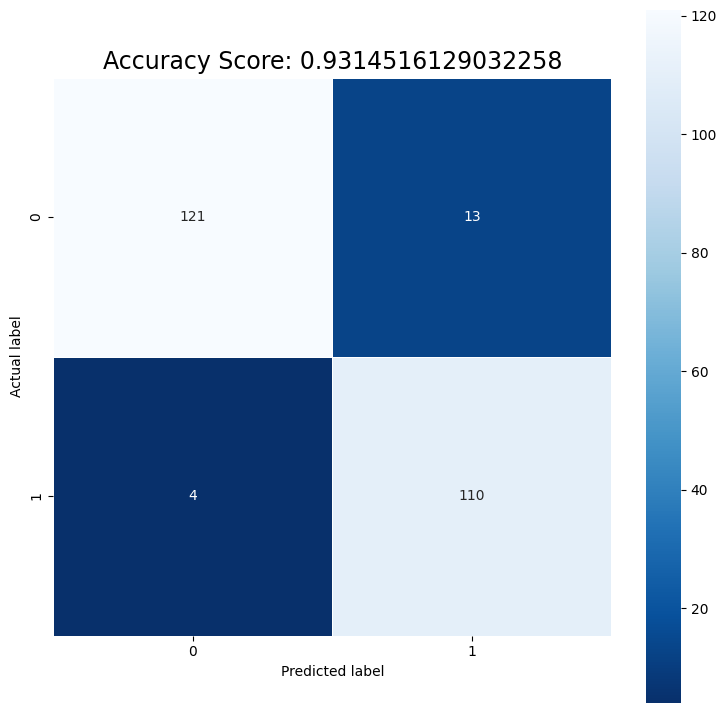

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the XGBoost model
xg = XGBClassifier(device='cuda', random_state=42)

# Define the hyperparameter grid for the search
param_dist = {
    'n_estimators': np.arange(50, 1000, 2),
    'max_depth': np.arange(1, 20, 1),
    'booster' : ['gbtree', 'dart'],
    'tree_method' : ['approx', 'hist'],
    'grow_policy' : ['depthwise', 'lossguide'],
    'learning_rate' : np.linspace(0.01, 0.5, 30)
}

# Configure RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xg, param_distributions=param_dist, scoring='f1', n_iter=50, cv=5, random_state=42, n_jobs=-1)

# Adjust the model
random_search.fit(x_train_binary, y_train_binary)

# Best hyperparameter combination
best_params = random_search.best_params_

# Evaluate the optimized model on the test set
best_estimator = random_search.best_estimator_

y_pred_test = best_estimator.predict(x_test_binary)
accuracy_test = accuracy_score(y_test_binary, y_pred_test)

y_pred_train = best_estimator.predict(x_train_binary)
accuracy_train = accuracy_score(y_train_binary, y_pred_train)


print(f"{best_params};{accuracy_train*100:.2f};{accuracy_test*100:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test_binary, y_pred_test)

print(classification_report(y_test_binary, y_pred_test))

score = best_estimator.score(x_test_binary, y_test_binary)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

XGBClassifier(random_state=r, verbosity=0, tree_method='approx', n_estimators=58, max_depth=5, learning_rate=0.24655172413793103, grow_policy='depthwise', booster='gbtree')

# **Exclude instances of no-smell from the training and test sets**


In [ ]:
finish = False
while (finish == False):
  try:
    max = x_train_multiclass.shape[0]
    # Exclude instances of no-smell from the training set (targets)
    for i in range(0, max):
      if (y_train_multiclass[i] == 0):
        y_train_multiclass = np.delete(y_train_multiclass, i, axis = 0)
        x_train_multiclass = np.delete(x_train_multiclass, i, axis = 0)
        i = 0
        max = max - 1
    finish = True
    print("The deletion is over in the y_train set!")
  except:
    finish == False


finish = False
while (finish == False):
  try:
    max = x_test_multiclass.shape[0]
    # Exclude instances of no-smell from the test set (predictors)
    for i in range(0, max):
      if (y_test_multiclass[i] == 0):
        y_test_multiclass = np.delete(y_test_multiclass, i, axis = 0)
        x_test_multiclass = np.delete(x_test_multiclass, i, axis = 0)
        i = 0
        max = max - 1
    finish = True
    print("The deletion is over in the x_train set!")
  except:
    finish = False

The deletion is over in the y_train set!
The deletion is over in the x_train set!


# Prepare training and test set for applying XGBoost

In [ ]:
for j in range(len(y_train_multiclass)):
    if y_train_multiclass[j] == 1.0:
      y_train_multiclass[j]= 0.0

for j in range(len(y_test_multiclass)):
    if y_test_multiclass[j] == 1.0:
      y_test_multiclass[j]= 0.0

for j in range(len(y_train_multiclass)):
    if y_train_multiclass[j] == 2.0:
      y_train_multiclass[j]= 1.0

for j in range(len(y_test_multiclass)):
    if y_test_multiclass[j] == 2.0:
      y_test_multiclass[j]= 1.0

for j in range(len(y_train_multiclass)):
    if y_train_multiclass[j] == 3.0:
      y_train_multiclass[j]= 2.0

for j in range(len(y_test_multiclass)):
    if y_test_multiclass[j] == 3.0:
      y_test_multiclass[j]= 2.0

for j in range(len(y_train_multiclass)):
    if y_train_multiclass[j] == 4.0:
      y_train_multiclass[j]= 3.0

for j in range(len(y_test_multiclass)):
    if y_test_multiclass[j] == 4.0:
      y_test_multiclass[j]= 3.0

for j in range(len(y_train_multiclass)):
    if y_train_multiclass[j] == 5.0:
      y_train_multiclass[j]= 4.0

for j in range(len(y_test_multiclass)):
    if y_test_multiclass[j] == 5.0:
      y_test_multiclass[j]= 4.0

for j in range(len(y_train_multiclass)):
    if y_train_multiclass[j] == 6.0:
      y_train_multiclass[j]= 5.0

for j in range(len(y_test_multiclass)):
    if y_test_multiclass[j] == 6.0:
      y_test_multiclass[j]= 5.0

for j in range(len(y_train_multiclass)):
    if y_train_multiclass[j] == 7.0:
      y_train_multiclass[j]= 6.0

for j in range(len(y_test_multiclass)):
    if y_test_multiclass[j] == 7.0:
      y_test_multiclass[j]= 6.0

for j in range(len(y_train_multiclass)):
    if y_train_multiclass[j] == 8.0:
      y_train_multiclass[j]= 7.0

for j in range(len(y_test_multiclass)):
    if y_test_multiclass[j] == 8.0:
      y_test_multiclass[j]= 7.0

for j in range(len(y_train_multiclass)):
    if y_train_multiclass[j] == 9.0:
      y_train_multiclass[j]= 8.0

for j in range(len(y_test_multiclass)):
    if y_test_multiclass[j] == 9.0:
      y_test_multiclass[j]= 8.0

for j in range(len(y_train_multiclass)):
    if y_train_multiclass[j] == 10.0:
      y_train_multiclass[j]= 9.0

for j in range(len(y_test_multiclass)):
    if y_test_multiclass[j] == 10.0:
      y_test_multiclass[j]= 9.0

for j in range(len(y_train_multiclass)):
    if y_train_multiclass[j] == 11.0:
      y_train_multiclass[j]= 10.0

for j in range(len(y_test_multiclass)):
    if y_test_multiclass[j] == 11.0:
      y_test_multiclass[j]= 10.0

for j in range(len(y_train_multiclass)):
    if y_train_multiclass[j] == 12.0:
      y_train_multiclass[j]= 11.0

for j in range(len(y_test_multiclass)):
    if y_test_multiclass[j] == 12.0:
      y_test_multiclass[j]= 11.0

# **Code Smell Severity Classification with three ensemble method**


# **OVERSAMPLING BORDERLINESMOTE**

In [ ]:
pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE

# OverSampling
sm = BorderlineSMOTE(random_state=42)
x_train_multiclass_res, y_train_multiclass_res = sm.fit_resample(x_train_multiclass, y_train_multiclass)

# **RANDOM FOREST**

# **Randomized**

{'n_estimators': 970, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': None, 'max_depth': 6, 'criterion': 'log_loss', 'bootstrap': True};90.64;77.19
              precision    recall  f1-score   support

         0.0       0.50      0.33      0.40         3
         1.0       0.70      0.88      0.78         8
         2.0       1.00      0.50      0.67         2
         3.0       0.00      0.00      0.00         2
         4.0       0.87      0.83      0.85        24
         5.0       0.70      0.88      0.78         8
         6.0       0.40      0.57      0.47         7
         7.0       0.81      0.72      0.76        18
         8.0       1.00      0.83      0.91         6
         9.0       1.00      0.50      0.67         2
        10.0       0.83      0.50      0.62        10
        11.0       0.83      1.00      0.91        24

    accuracy                           0.77       114
   macro avg       0.72      0.63      0.65       114
weighted avg       0.78  

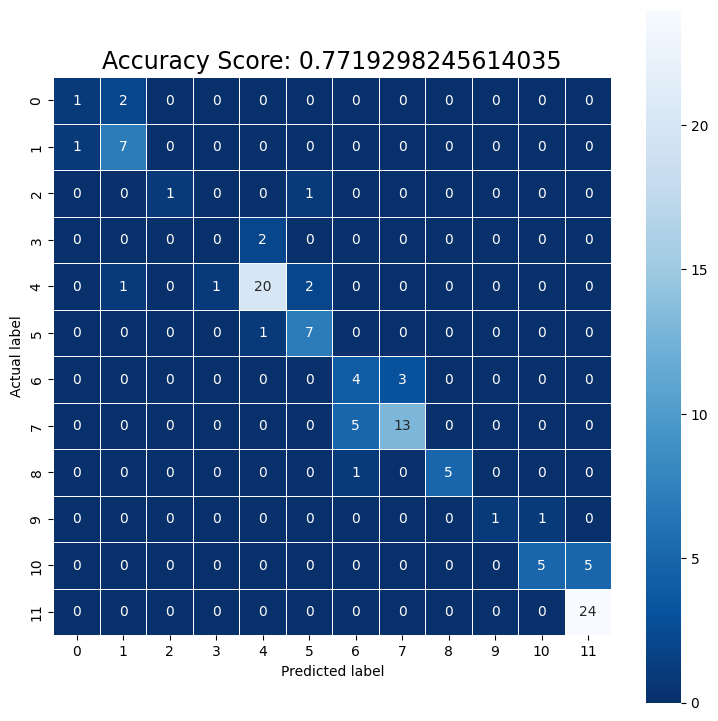

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid for the search
param_dist = {
    'n_estimators': np.arange(50, 1000, 2),
    'criterion': ['entropy', 'gini', 'log_loss'],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': np.arange(1, 20, 1),
    'min_samples_split': np.arange(2, 20, 1),
    'min_samples_leaf': np.arange(1, 20, 1),
    'bootstrap': [True, False]
}

# Configure RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, scoring='f1_macro', n_iter=50, cv=5, random_state=42, n_jobs=-1)

# Adjust the model
random_search.fit(x_train_multiclass, y_train_multiclass)

# Best hyperparameter combination
best_params = random_search.best_params_

# Evaluate the optimized model on the test set
best_estimator = random_search.best_estimator_
y_pred_test = best_estimator.predict(x_test_multiclass)
y_pred_train = best_estimator.predict(x_train_multiclass)
accuracy_train = accuracy_score(y_train_multiclass, y_pred_train)
accuracy_test = accuracy_score(y_test_multiclass, y_pred_test)

print(f"{best_params};{accuracy_train*100:.2f};{accuracy_test*100:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test_multiclass, y_pred_test)

print(classification_report(y_test_multiclass, y_pred_test))

score = best_estimator.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **BoderlineSMOTE**

{'n_estimators': 524, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 13, 'criterion': 'entropy', 'bootstrap': False};98.47;68.42
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50         3
         1.0       0.70      0.88      0.78         8
         2.0       0.00      0.00      0.00         2
         3.0       0.00      0.00      0.00         2
         4.0       0.80      0.83      0.82        24
         5.0       0.88      0.88      0.88         8
         6.0       0.38      0.71      0.50         7
         7.0       0.57      0.22      0.32        18
         8.0       0.36      0.67      0.47         6
         9.0       1.00      0.50      0.67         2
        10.0       0.83      0.50      0.62        10
        11.0       0.83      1.00      0.91        24

    accuracy                           0.68       114
   macro avg       0.61      0.54      0.54       114
weighted avg       0.

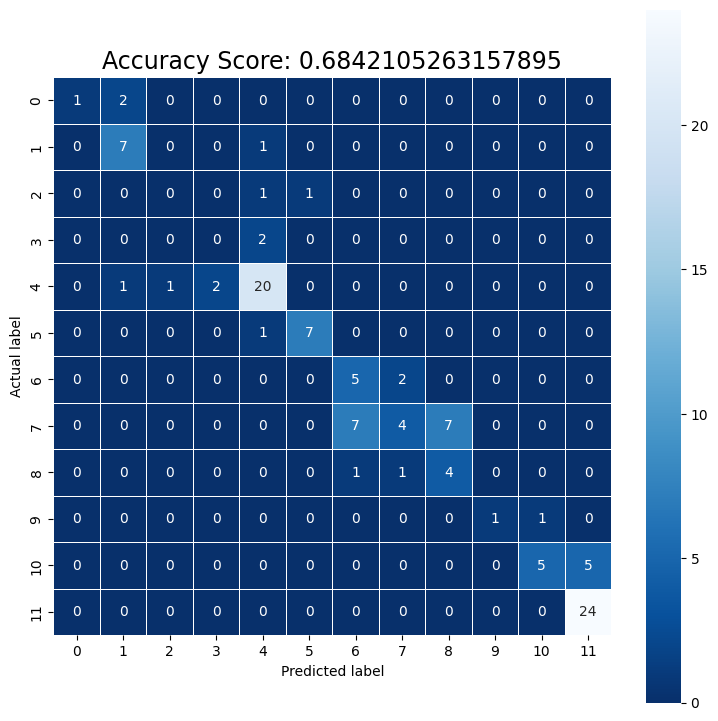

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid for the search
param_dist = {
    'n_estimators': np.arange(50, 1000, 2),
    'criterion': ['entropy', 'gini', 'log_loss'],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': np.arange(1, 20, 1),
    'min_samples_split': np.arange(2, 20, 1),
    'min_samples_leaf': np.arange(1, 20, 1),
    'bootstrap': [True, False]
}

# Configure RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, scoring='f1_macro', n_iter=50, cv=5, random_state=42, n_jobs=-1)

# Adjust the model
random_search.fit(x_train_multiclass_res, y_train_multiclass_res)

# Best hyperparameter combination
best_params = random_search.best_params_

# Evaluate the optimized model on the test set
best_estimator = random_search.best_estimator_

y_pred_test = best_estimator.predict(x_test_multiclass)
accuracy_test = accuracy_score(y_test_multiclass, y_pred_test)

y_pred_train = best_estimator.predict(x_train_multiclass_res)
accuracy_train = accuracy_score(y_train_multiclass_res, y_pred_train)

print(f"{best_params};{accuracy_train*100:.2f};{accuracy_test*100:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test_multiclass, y_pred_test)

print(classification_report(y_test_multiclass, y_pred_test))

score = best_estimator.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **EXTREME GRADIENTE BOOSTING (XGBOOST)**

# **Randomized**

{'tree_method': 'hist', 'objective': 'multi:softprob', 'n_estimators': 998, 'max_depth': 6, 'learning_rate': 0.31413793103448273, 'grow_policy': 'lossguide', 'booster': 'dart'};99.67;73.68
              precision    recall  f1-score   support

         0.0       0.71      0.91      0.80        11
         1.0       0.00      0.00      0.00         2
         2.0       0.50      0.50      0.50         2
         3.0       0.90      0.79      0.84        24
         4.0       0.88      0.88      0.88         8
         5.0       0.50      0.71      0.59         7
         6.0       0.75      0.50      0.60        18
         7.0       0.50      0.83      0.62         6
         8.0       1.00      0.50      0.67         2
         9.0       0.62      0.50      0.56        10
        10.0       0.81      0.92      0.86        24

    accuracy                           0.74       114
   macro avg       0.65      0.64      0.63       114
weighted avg       0.75      0.74      0.73       114

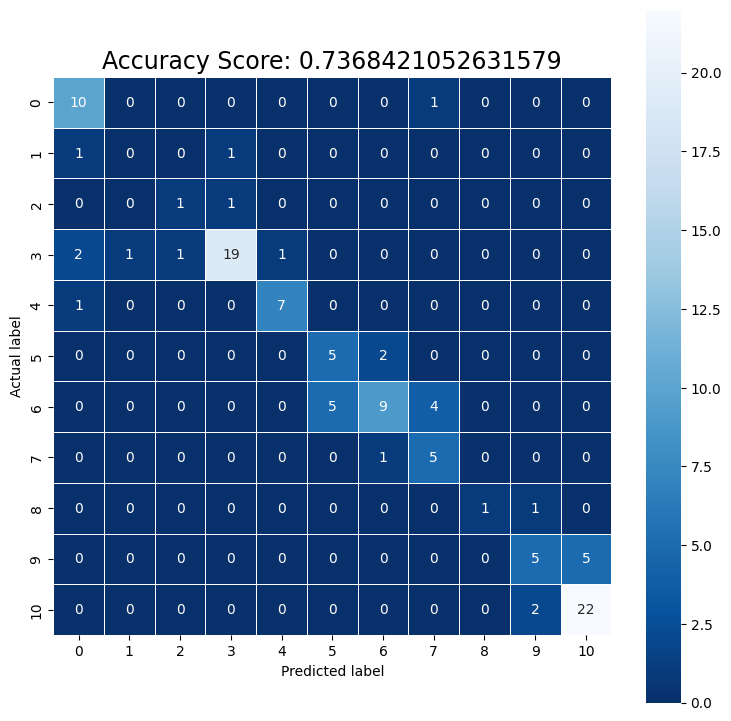

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the XGBoost model
xg = XGBClassifier(num_class=12, random_state=42)

# Define the hyperparameter grid for the search
param_dist = {
    'objective': ['multi:softprob', 'multi:softmax'],
    'n_estimators': np.arange(50, 1000, 2),
    'max_depth': np.arange(1, 20, 1),
    'booster' : ['gbtree', 'dart'],
    'tree_method' : ['approx', 'hist'],
    'grow_policy' : ['depthwise', 'lossguide'],
    'learning_rate' : np.linspace(0.01, 0.5, 30)
}

# Configure RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xg, param_distributions=param_dist, scoring='f1_macro', n_iter=50, cv=5, random_state=42, n_jobs=-1)

# Adjust the model
random_search.fit(x_train_multiclass, y_train_multiclass)

# Best hyperparameter combination
best_params = random_search.best_params_

# Evaluate the optimized model on the test set
best_estimator = random_search.best_estimator_
y_pred_test = best_estimator.predict(x_test_multiclass)
y_pred_train = best_estimator.predict(x_train_multiclass)
accuracy_train = accuracy_score(y_train_multiclass, y_pred_train)
accuracy_test = accuracy_score(y_test_multiclass, y_pred_test)

print(f"{best_params};{accuracy_train*100:.2f};{accuracy_test*100:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test_multiclass, y_pred_test)

print(classification_report(y_test_multiclass, y_pred_test))

score = best_estimator.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **BoderlineSMOTE**

{'tree_method': 'hist', 'objective': 'multi:softprob', 'n_estimators': 998, 'max_depth': 6, 'learning_rate': 0.31413793103448273, 'grow_policy': 'lossguide', 'booster': 'dart'};99.83;69.30
              precision    recall  f1-score   support

         0.0       0.33      0.33      0.33         3
         1.0       0.60      0.75      0.67         8
         2.0       0.00      0.00      0.00         2
         3.0       0.33      0.50      0.40         2
         4.0       0.89      0.71      0.79        24
         5.0       0.80      1.00      0.89         8
         6.0       0.45      0.71      0.56         7
         7.0       0.75      0.33      0.46        18
         8.0       0.38      0.83      0.53         6
         9.0       1.00      0.50      0.67         2
        10.0       0.70      0.70      0.70        10
        11.0       0.88      0.92      0.90        24

    accuracy                           0.69       114
   macro avg       0.59      0.61      0.57       114

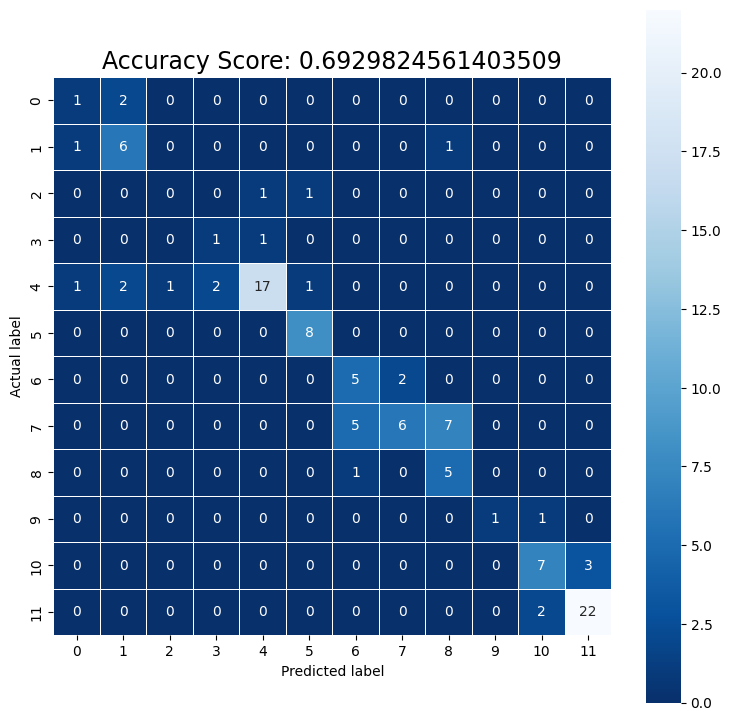

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the XGBoost model
xg = XGBClassifier(num_class=12, random_state=42)

# Define the hyperparameter grid for the search
param_dist = {
    'objective': ['multi:softprob', 'multi:softmax'],
    'n_estimators': np.arange(50, 1000, 2),
    'max_depth': np.arange(1, 20, 1),
    'booster' : ['gbtree', 'dart'],
    'tree_method' : ['approx', 'hist'],
    'grow_policy' : ['depthwise', 'lossguide'],
    'learning_rate' : np.linspace(0.01, 0.5, 30)
}

# Configure RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xg, param_distributions=param_dist, scoring='f1_macro', n_iter=50, cv=5, random_state=42, n_jobs=-1)

# Adjust the model
random_search.fit(x_train_multiclass_res, y_train_multiclass_res)

# Best hyperparameter combination
best_params = random_search.best_params_

# Evaluate the optimized model on the test set
best_estimator = random_search.best_estimator_

y_pred_test = best_estimator.predict(x_test_multiclass)
accuracy_test = accuracy_score(y_test_multiclass, y_pred_test)

y_pred_train = best_estimator.predict(x_train_multiclass_res)
accuracy_train = accuracy_score(y_train_multiclass_res, y_pred_train)

print(f"{best_params};{accuracy_train*100:.2f};{accuracy_test*100:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test_multiclass, y_pred_test)

print(classification_report(y_test_multiclass, y_pred_test))

score = best_estimator.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **CATEGORICAL BOOSTING (CATBOOST)**

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 24.0 MB/s eta 0:00:00


# **Randomized**

MultiClassOneVsAll

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the CatBoost model
cat = CatBoostClassifier(task_type='CPU', thread_count=-1, random_state = 42, verbose=False, classes_count=12)

# Define the hyperparameter grid for the search
param_dist = {
    'objective': ['MultiClass', 'MultiClassOneVsAll'],
    'iterations': np.arange(50, 1000, 2),
    'depth': np.arange(1, 16, 1),
    'learning_rate': np.linspace(0.01, 0.5, 30),
    'l2_leaf_reg': np.arange(1, 10, 1),
    'border_count': np.arange(32, 256, 16),
    'feature_border_type' : ['Median', 'Uniform', 'UniformAndQuantiles', 'GreedyLogSum', 'MaxLogSum', 'MinEntropy'],
    'leaf_estimation_method' : ['Newton', 'Gradient'],
    'auto_class_weights' : ['Balanced', 'SqrtBalanced'],
    'grow_policy' : ['SymmetricTree', 'Lossguide', 'Depthwise'],
    'bootstrap_type' : ['Bayesian', 'Bernoulli', 'MVS', 'No']
}

# Configure RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=cat, param_distributions=param_dist, scoring='f1_macro', n_iter=50, cv=5, random_state=42, n_jobs=-1)

# Adjust the model
random_search.fit(x_train_multiclass, y_train_multiclass)

# Best hyperparameter combination
best_params = random_search.best_params_

# Evaluate the optimized model on the test set
best_estimator = random_search.best_estimator_
y_pred_test = best_estimator.predict(x_test_multiclass)
y_pred_train = best_estimator.predict(x_train_multiclass)
accuracy_train = accuracy_score(y_train_multiclass, y_pred_train)
accuracy_test = accuracy_score(y_test_multiclass, y_pred_test)

print(f"{best_params};{accuracy_train*100:.2f};{accuracy_test*100:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test_multiclass, y_pred_test)

print(classification_report(y_test_multiclass, y_pred_test))

score = best_estimator.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

#**BorderlineSMOTE**

{'learning_rate': 0.21275862068965518, 'leaf_estimation_method': 'Newton', 'l2_leaf_reg': 5, 'iterations': 696, 'grow_policy': 'SymmetricTree', 'feature_border_type': 'MaxLogSum', 'depth': 7, 'border_count': 144, 'bootstrap_type': 'Bayesian', 'auto_class_weights': 'SqrtBalanced'};99.83;67.54
              precision    recall  f1-score   support

         0.0       0.33      0.33      0.33         3
         1.0       0.57      0.50      0.53         8
         2.0       0.00      0.00      0.00         2
         3.0       0.33      0.50      0.40         2
         4.0       0.83      0.79      0.81        24
         5.0       0.70      0.88      0.78         8
         6.0       0.38      0.71      0.50         7
         7.0       0.67      0.22      0.33        18
         8.0       0.42      0.83      0.56         6
         9.0       1.00      0.50      0.67         2
        10.0       0.73      0.80      0.76        10
        11.0       0.92      0.92      0.92        24

   

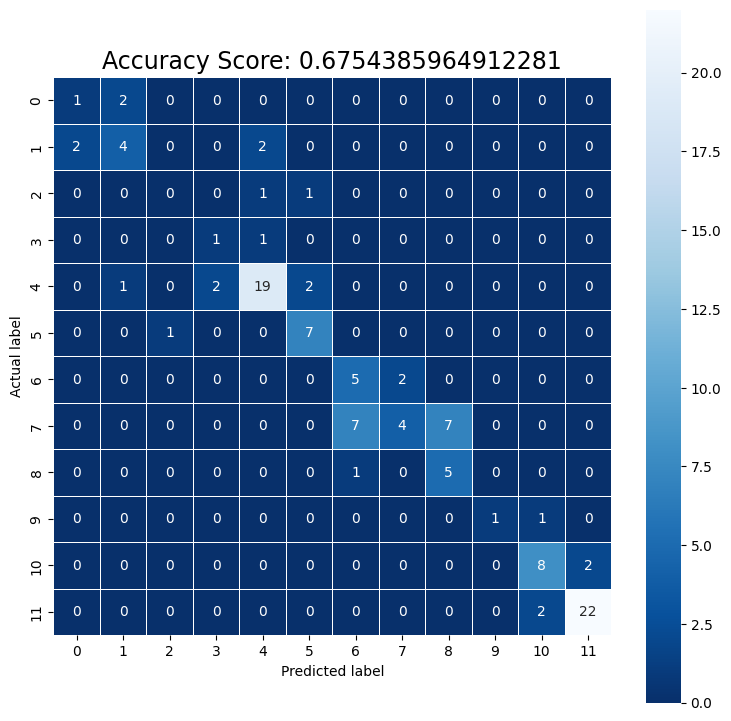

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the CatBoost model
cat = CatBoostClassifier(task_type='CPU', thread_count=-1, random_state = 42, verbose=False, classes_count=12, objective='MultiClassOneVsAll')

# Define the hyperparameter grid for the search
param_dist = {
    'iterations': np.arange(50, 1000, 2),
    'depth': np.arange(1, 16, 1),
    'learning_rate': np.linspace(0.01, 0.5, 30),
    'l2_leaf_reg': np.arange(1, 10, 1),
    'border_count': np.arange(32, 256, 16),
    'feature_border_type' : ['Median', 'Uniform', 'UniformAndQuantiles', 'GreedyLogSum', 'MaxLogSum', 'MinEntropy'],
    'leaf_estimation_method' : ['Newton', 'Gradient'],
    'auto_class_weights' : ['Balanced', 'SqrtBalanced'],
    'grow_policy' : ['SymmetricTree', 'Lossguide', 'Depthwise'],
    'bootstrap_type' : ['Bayesian', 'Bernoulli', 'MVS', 'No']
}

# Configure RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=cat, param_distributions=param_dist, scoring='f1_macro', n_iter=50, cv=5, random_state=42, n_jobs=-1)

# Adjust the model
random_search.fit(x_train_multiclass_res, y_train_multiclass_res)

# Best hyperparameter combination
best_params = random_search.best_params_

# Evaluate the optimized model on the test set
best_estimator = random_search.best_estimator_

y_pred_test = best_estimator.predict(x_test_multiclass)
accuracy_test = accuracy_score(y_test_multiclass, y_pred_test)

y_pred_train = best_estimator.predict(x_train_multiclass_res)
accuracy_train = accuracy_score(y_train_multiclass_res, y_pred_train)

print(f"{best_params};{accuracy_train*100:.2f};{accuracy_test*100:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test_multiclass, y_pred_test)

print(classification_report(y_test_multiclass, y_pred_test))

score = best_estimator.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()